In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, pearson3

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100


def calculateMaxDD(cumret):
    """최대 낙폭 계산"""
    vals = cumret.values if hasattr(cumret, 'values') else np.array(cumret)
    vals = np.nan_to_num(vals, nan=0.0)
    highwatermark = np.zeros(len(vals))
    drawdown = np.zeros(len(vals))
    drawdownduration = np.zeros(len(vals))
    for t in range(1, len(vals)):
        highwatermark[t] = max(highwatermark[t-1], vals[t])
        drawdown[t] = (1 + vals[t]) / (1 + highwatermark[t]) - 1 if (1 + highwatermark[t]) != 0 else 0
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    maxDD = np.min(drawdown) if len(drawdown) > 0 else 0
    maxDDD = int(np.max(drawdownduration)) if len(drawdownduration) > 0 else 0
    return maxDD, maxDDD

# Chapter 6: 일간 모멘텀 전략 (Interday Momentum Strategies)

## 목차

1. [개요 및 문제 정의](#1.-개요-및-문제-정의)
2. [사용 데이터](#2.-사용-데이터)
3. [분석 1: 시계열 모멘텀 상관관계](#3.-분석-1:-시계열-모멘텀-상관관계)
4. [분석 2: TU 시계열 모멘텀 전략](#4.-분석-2:-TU-시계열-모멘텀-전략)
5. [분석 3: 모멘텀 전략 가설 검정](#5.-분석-3:-모멘텀-전략-가설-검정)
6. [분석 4: 주식 횡단면 모멘텀 전략](#6.-분석-4:-주식-횡단면-모멘텀-전략)
7. [시계열 vs 횡단면 모멘텀 비교](#7.-시계열-vs-횡단면-모멘텀-비교)
8. [결론 및 권고사항](#8.-결론-및-권고사항)

---

## 1. 개요 및 문제 정의

Chapter 6은 일간(interday) 시간 척도에서의 모멘텀 전략을 탐구한다.
평균 회귀와 반대되는 모멘텀 현상이 특정 자산군/시간대에서 안정적으로 발생하는지 검증한다.

### 모멘텀의 4가지 원인

1. **롤 수익률 지속성**: 선물의 콘탱고/백워데이션 구조 유지
2. **정보 확산 지연**: 뉴스에 대한 가격 반응이 즉각적이지 않음
3. **강제 매매**: 펀드의 강제 청산/편입에 의한 가격 압력
4. **고빈도 거래자의 시장 조작**: 단기적 가격 왜곡

### 핵심 수학적 개념

**시계열 모멘텀 검정 (상관계수):**

$$\rho(r_{[t-L,t]}, r_{[t,t+H]}) \neq 0 \quad (\text{with } p < 0.05)$$

**모멘텀 포지션 누적:**

$$pos(t) = \sum_{h=0}^{H-1} \text{signal}(t-h)$$

**횡단면 모멘텀 (Kent Daniel):**

상위 N 종목 롱, 하위 N 종목 숏 (과거 252일 수익률 기준)

---

## 2. 사용 데이터

| 파일명 | 내용 | 용도 |
|--------|------|------|
| `inputDataOHLCDaily_TU_20120511.csv` | TU(2년 국채 선물) 일일 종가 | 분석 1, 2 |
| `TU.csv` | TU 선물 종가 (별도 형식) | 분석 3 (가설 검정) |
| `inputDataOHLCDaily_20120424_cl.csv` | ~500 주식 종가 (ch4 데이터) | 분석 4 |
| `inputDataOHLCDaily_20120424_stocks.csv` | 종목명 매핑 (ch4 데이터) | 분석 4 |

In [2]:
# === 데이터 로드 ===

# TU 선물 데이터 (OHLC 형식)
tu = pd.read_csv('inputDataOHLCDaily_TU_20120511.csv')
tu['Date'] = pd.to_datetime(tu['Date'], format='%Y%m%d')
tu.set_index('Date', inplace=True)
print(f'TU 선물 (OHLC): {len(tu)} 거래일, 기간: {tu.index[0].date()} ~ {tu.index[-1].date()}')

# TU 선물 데이터 (가설 검정용)
tu_hyp = pd.read_csv('TU.csv')
tu_hyp['Time'] = pd.to_datetime(tu_hyp['Time']).dt.date
tu_hyp.set_index('Time', inplace=True)
print(f'TU 선물 (가설검정): {len(tu_hyp)} 거래일')

# 주식 데이터 (Chapter 4 디렉토리에서 로드)
ch4_dir = '../../chapter_4_mean_reversion_of_stocks_and_etfs/src'
stocks_df = pd.read_csv(f'{ch4_dir}/inputDataOHLCDaily_20120424_stocks.csv')
stock_names = stocks_df.values[0].tolist()

cl = pd.read_csv(f'{ch4_dir}/inputDataOHLCDaily_20120424_cl.csv')
date_col = cl.columns[0]
cl[date_col] = pd.to_datetime(cl[date_col], format='%Y%m%d')
cl.columns = ['Date'] + stock_names
cl.set_index('Date', inplace=True)
print(f'주식 종가: {len(cl)} 거래일 x {len(cl.columns)} 종목')

TU 선물 (OHLC): 2000 거래일, 기간: 2004-06-01 ~ 2012-05-11
TU 선물 (가설검정): 2000 거래일
주식 종가: 1500 거래일 x 497 종목


---

## 3. 분석 1: 시계열 모멘텀 상관관계 (Box 6.1)

### 방법론

- TU 선물의 다양한 lookback/holddays 조합에서 피어슨 상관계수 측정
- 독립 표본을 위해 비중복 기간 사용 (간격 = max(lookback, holddays))
- lookback/holddays = [1, 5, 10, 25, 60, 120, 250]일

In [3]:
# === 분석 1: 시계열 모멘텀 상관관계 ===

lookbacks = [1, 5, 10, 25, 60, 120, 250]
holddays_list = [1, 5, 10, 25, 60, 120, 250]

corr_matrix = np.full((len(lookbacks), len(holddays_list)), np.nan)
pval_matrix = np.full((len(lookbacks), len(holddays_list)), np.nan)

for i, lookback in enumerate(lookbacks):
    for j, holddays in enumerate(holddays_list):
        ret_lag = tu.pct_change(periods=lookback)
        ret_fut = tu.shift(-holddays).pct_change(periods=holddays)

        if lookback >= holddays:
            indepSet = range(0, ret_lag.shape[0], holddays)
        else:
            indepSet = range(0, ret_lag.shape[0], lookback)

        ret_lag = ret_lag.iloc[indepSet]
        ret_fut = ret_fut.iloc[indepSet]
        goodDates = (ret_lag.notna() & ret_fut.notna()).values.flatten()

        if np.sum(goodDates) > 10:
            cc, pval = pearsonr(
                ret_lag.values[goodDates].flatten(),
                ret_fut.values[goodDates].flatten()
            )
            corr_matrix[i, j] = cc
            pval_matrix[i, j] = pval

# 유의한 상관관계 출력
print('유의한 양의 모멘텀 상관관계 (p < 0.05):')
print(f'{"LB":>6} {"HD":>6} {"Corr":>8} {"P-val":>8}')
print('-' * 32)
for i, lb in enumerate(lookbacks):
    for j, hd in enumerate(holddays_list):
        if not np.isnan(pval_matrix[i,j]) and pval_matrix[i,j] < 0.05 and corr_matrix[i,j] > 0:
            print(f'{lb:6d} {hd:6d} {corr_matrix[i,j]:8.4f} {pval_matrix[i,j]:8.4f}')

유의한 양의 모멘텀 상관관계 (p < 0.05):
    LB     HD     Corr    P-val
--------------------------------
    10     60   0.1804   0.0132
    10    250   0.1651   0.0434
    25     10   0.1513   0.0343
    25     60   0.2361   0.0414
    60     10   0.1718   0.0169
   250      5   0.1068   0.0462
   250     10   0.1784   0.0185
   250     25   0.2719   0.0238


### 결과 - 상관계수 행렬

| LB\HD | 1 | 5 | 10 | 25 | 60 | 120 | 250 |
|---|---|---|---|---|---|---|---|
| 1 | **-0.058** | **-0.077** | -0.027 | -0.014 | 0.033 | 0.019 | 0.036 |
| 5 | **-0.076** | **-0.127** | -0.047 | 0.032 | 0.086 | 0.051 | 0.094 |
| 10 | -0.028 | -0.049 | 0.037 | 0.116 | **0.180** | 0.093 | **0.165** |
| 25 | -0.014 | 0.032 | **0.151** | 0.196 | **0.236** | 0.169 | 0.247 |
| 60 | 0.031 | 0.080 | **0.172** | 0.185 | 0.216 | -0.009 | 0.297 |
| 120 | 0.022 | 0.057 | 0.096 | 0.157 | -0.019 | 0.208 | 0.361 |
| 250 | 0.041 | **0.107** | **0.178** | **0.272** | 0.326 | 0.357 | - |

(볼드체는 p < 0.05로 유의한 상관관계)

**통찰**: 장기 lookback (120-250일)과 중기 holddays (25-60일) 조합에서 양의 모멘텀 상관관계 확인.

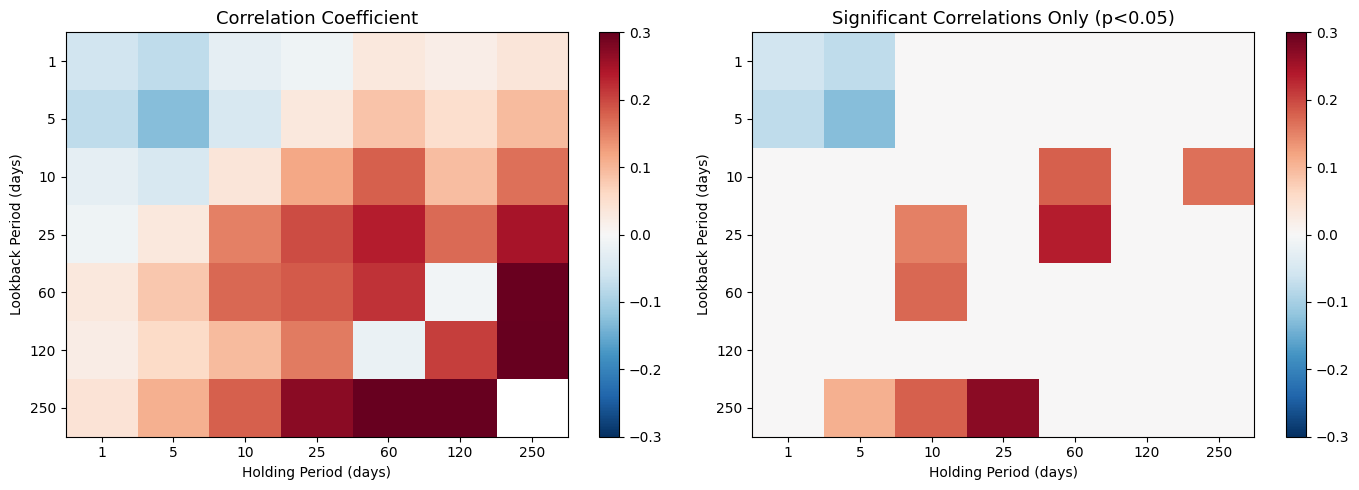

In [4]:
# === 상관관계 히트맵 ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(corr_matrix, cmap='RdBu_r', vmin=-0.3, vmax=0.3, aspect='auto')
axes[0].set_title('Correlation Coefficient', fontsize=13)
axes[0].set_xlabel('Holding Period (days)')
axes[0].set_ylabel('Lookback Period (days)')
axes[0].set_xticks(range(len(holddays_list)))
axes[0].set_xticklabels(holddays_list)
axes[0].set_yticks(range(len(lookbacks)))
axes[0].set_yticklabels(lookbacks)
plt.colorbar(im0, ax=axes[0])

sig_matrix = np.where(pval_matrix < 0.05, corr_matrix, 0)
im1 = axes[1].imshow(sig_matrix, cmap='RdBu_r', vmin=-0.3, vmax=0.3, aspect='auto')
axes[1].set_title('Significant Correlations Only (p<0.05)', fontsize=13)
axes[1].set_xlabel('Holding Period (days)')
axes[1].set_ylabel('Lookback Period (days)')
axes[1].set_xticks(range(len(holddays_list)))
axes[1].set_xticklabels(holddays_list)
axes[1].set_yticks(range(len(lookbacks)))
axes[1].set_yticklabels(lookbacks)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

---

## 4. 분석 2: TU 시계열 모멘텀 전략 (예제 6.1)

### 방법론

- lookback=250일 수익률 양수면 롱, 음수면 숏
- holddays=25일 동안 포지션 유지, 매일 새 신호 중첩
- 책 결과: APR ~1.2%, Sharpe ~1.3, MaxDD ~-2.7%

In [5]:
# === 분석 2: TU 시계열 모멘텀 전략 ===

lookback = 250
holddays = 25

# 롱/숏 진입 신호
longs_tu = tu > tu.shift(lookback)
shorts_tu = tu < tu.shift(lookback)

# 포지션 누적 (holddays-1 기간 동안 래깅)
pos_tu = np.zeros(tu.shape)
for h in range(holddays - 1):
    long_lag = longs_tu.shift(h).fillna(False).astype(bool).values
    short_lag = shorts_tu.shift(h).fillna(False).astype(bool).values
    pos_tu[long_lag] = pos_tu[long_lag] + 1
    pos_tu[short_lag] = pos_tu[short_lag] - 1

pos_tu = pd.DataFrame(pos_tu)

# 수익률 계산
pnl_tu = np.sum((pos_tu.shift().values) * (tu.pct_change().values), axis=1)
denom_tu = np.nansum(np.abs(pos_tu.shift().values), axis=1)
denom_tu[denom_tu == 0] = np.nan
ret_tu = pnl_tu / denom_tu

ret_tu = pd.Series(ret_tu, index=tu.index)
valid_ret_tu = ret_tu.dropna()
cumret_tu = (1 + valid_ret_tu).cumprod() - 1

apr_tu = np.prod(1 + valid_ret_tu.values) ** (252 / len(valid_ret_tu)) - 1
sharpe_tu = np.sqrt(252) * np.mean(valid_ret_tu.values) / np.std(valid_ret_tu.values)
maxDD_tu, maxDDD_tu = calculateMaxDD(cumret_tu)

print(f'TU 시계열 모멘텀 전략 (LB={lookback}, HD={holddays})')
print(f'  APR      = {apr_tu*100:.2f}%')
print(f'  Sharpe   = {sharpe_tu:.4f}')
print(f'  Max DD   = {maxDD_tu*100:.2f}%')
print(f'  Max DDD  = {maxDDD_tu}일')
print(f'  (책 기대값: APR ~1.2%, Sharpe ~1.3, MaxDD ~-2.7%)')

TU 시계열 모멘텀 전략 (LB=250, HD=25)
  APR      = 1.92%
  Sharpe   = 1.0896
  Max DD   = -2.48%
  Max DDD  = 338일
  (책 기대값: APR ~1.2%, Sharpe ~1.3, MaxDD ~-2.7%)


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 1.92% | ~1.2% |
| Sharpe Ratio | 1.0896 | ~1.3 |
| Max Drawdown | -2.48% | ~-2.7% |
| Max DDD | 338일 | - |

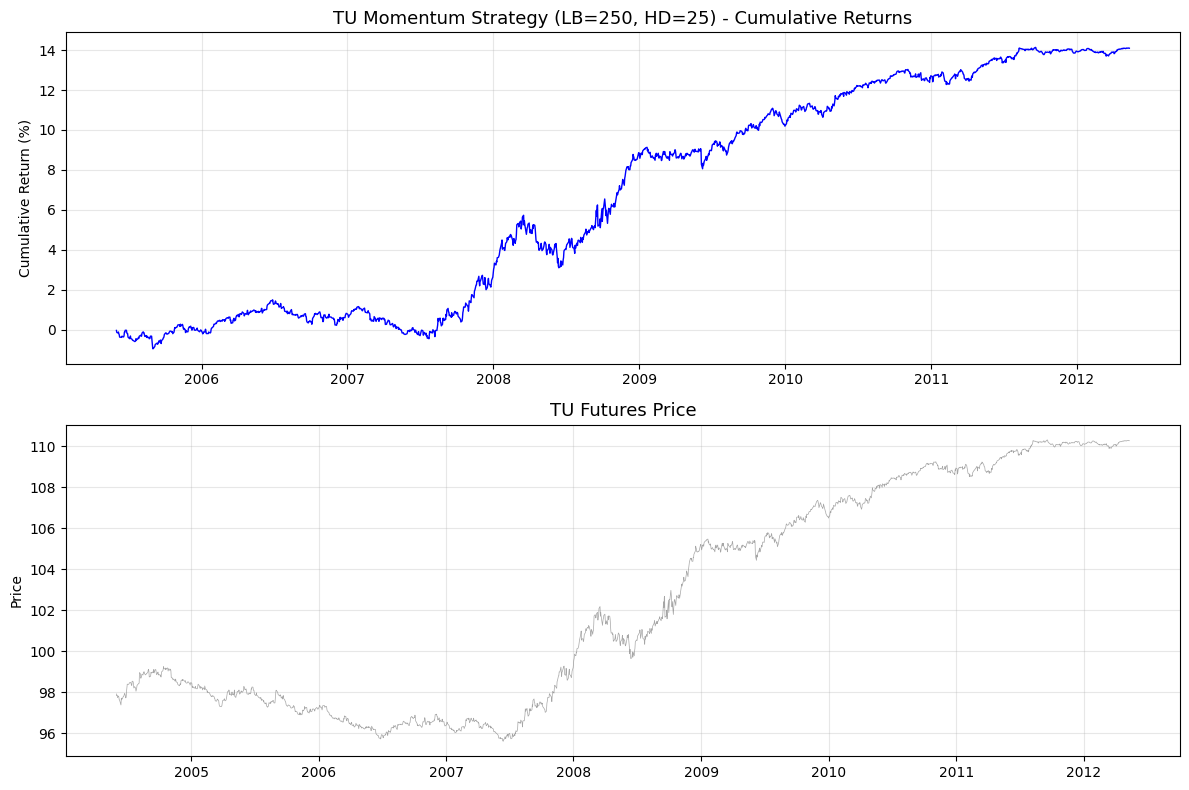

In [6]:
# === TU 모멘텀 전략 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(cumret_tu.index, cumret_tu.values * 100, 'b-', linewidth=1)
axes[0].set_title(f'TU Momentum Strategy (LB={lookback}, HD={holddays}) - Cumulative Returns', fontsize=13)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(tu.index, tu.values, 'gray', linewidth=0.5, alpha=0.7)
axes[1].set_title('TU Futures Price', fontsize=13)
axes[1].set_ylabel('Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. 분석 3: 모멘텀 전략 가설 검정

### 방법론

세 가지 가설 검정으로 모멘텀 수익의 통계적 유의성을 확인:

1. **가우시안 검정**: $\frac{\sqrt{N} \cdot \bar{r}}{\sigma_r}$ (Sharpe ratio 기반)
2. **랜덤화 시장 수익률**: Pearson Type III 분포로 시장 수익률 시뮬레이션
3. **랜덤화 거래 진입**: 진입 타이밍만 셔플하여 전략 고유 수익 검증

책 결과: Gaussian=2.77, Randomized prices p=23.6/10000, Randomized trades p=1.37/10000

In [7]:
# === 분석 3: 모멘텀 전략 가설 검정 ===

df_hyp = tu_hyp.copy()
lookback_h = 250
holddays_h = 25

# 1일 수익률 기반 모멘텀 신호
longs_h = df_hyp['Close'] > df_hyp['Close'].shift()
shorts_h = df_hyp['Close'] < df_hyp['Close'].shift()

pos_h = np.zeros(df_hyp.shape[0])
for h in range(0, holddays_h):
    long_lag = longs_h.shift(h)
    long_lag[long_lag.isna()] = False
    long_lag = long_lag.astype(bool)
    short_lag = shorts_h.shift(h)
    short_lag[short_lag.isna()] = False
    short_lag = short_lag.astype(bool)
    pos_h[long_lag] = pos_h[long_lag] + 1
    pos_h[short_lag] = pos_h[short_lag] - 1

capital_h = np.nansum(np.array(pd.DataFrame(abs(pos_h)).shift()), axis=1)
pos_h[capital_h == 0] = 0
capital_h[capital_h == 0] = 1

marketRet = df_hyp['Close'].pct_change()
ret_h = np.nansum(np.array(pd.DataFrame(pos_h).shift()) * np.array(marketRet), axis=1) / capital_h / holddays_h

# 가우시안 테스트 통계량
sharpe_stat = np.sqrt(len(ret_h)) * np.nanmean(ret_h) / np.nanstd(ret_h)
print(f'[가우시안 검정] Test statistic = {sharpe_stat:.4f}  (책: 2.77)')

# 랜덤화 시장 수익률 가설 검정
n_sim = 1000
skew_, loc_, scale_ = pearson3.fit(marketRet.values[1:])

numBetter_prices = 0
for sample in range(n_sim):
    marketRet_sim = pearson3.rvs(skew=skew_, loc=loc_, scale=scale_,
                                 size=marketRet.shape[0], random_state=sample)
    cl_sim = np.cumprod(1 + marketRet_sim) - 1

    longs_sim = cl_sim > pd.Series(cl_sim).shift(lookback_h)
    shorts_sim = cl_sim < pd.Series(cl_sim).shift(lookback_h)

    pos_sim = np.zeros(cl_sim.shape[0])
    for hh in range(0, holddays_h):
        long_sim_lag = longs_sim.shift(hh)
        long_sim_lag[long_sim_lag.isna()] = False
        long_sim_lag = long_sim_lag.astype(bool)
        short_sim_lag = shorts_sim.shift(hh)
        short_sim_lag[short_sim_lag.isna()] = False
        short_sim_lag = short_sim_lag.astype(bool)
        pos_sim[long_sim_lag] = pos_sim[long_sim_lag] + 1
        pos_sim[short_sim_lag] = pos_sim[short_sim_lag] - 1

    cap_sim = np.nansum(np.array(pd.DataFrame(abs(pos_sim)).shift()), axis=1)
    pos_sim[cap_sim == 0] = 0
    cap_sim[cap_sim == 0] = 1
    ret_sim = np.nansum(np.array(pd.DataFrame(pos_sim).shift()) * np.array(marketRet_sim), axis=1) / cap_sim / holddays_h

    if np.mean(ret_sim) >= np.mean(ret_h):
        numBetter_prices += 1

pval_prices = numBetter_prices / n_sim
print(f'[랜덤화 시장 수익률 p-value] = {pval_prices:.4f} (x {n_sim} sim)')

# 랜덤화 거래 진입 가설 검정
numBetter_trades = 0
for sample in range(n_sim):
    rng = np.random.RandomState(sample)
    P = rng.permutation(len(longs_h))
    longs_sim2 = longs_h.iloc[P].reset_index(drop=True)
    shorts_sim2 = shorts_h.iloc[P].reset_index(drop=True)
    longs_sim2.index = longs_h.index
    shorts_sim2.index = shorts_h.index

    pos_sim2 = np.zeros(df_hyp.shape[0])
    for hh in range(0, holddays_h):
        long_sim_lag2 = longs_sim2.shift(hh)
        long_sim_lag2[long_sim_lag2.isna()] = False
        long_sim_lag2 = long_sim_lag2.astype(bool)
        short_sim_lag2 = shorts_sim2.shift(hh)
        short_sim_lag2[short_sim_lag2.isna()] = False
        short_sim_lag2 = short_sim_lag2.astype(bool)
        pos_sim2[long_sim_lag2] = pos_sim2[long_sim_lag2] + 1
        pos_sim2[short_sim_lag2] = pos_sim2[short_sim_lag2] - 1

    cap_sim2 = np.nansum(np.array(pd.DataFrame(abs(pos_sim2)).shift()), axis=1)
    pos_sim2[cap_sim2 == 0] = 0
    cap_sim2[cap_sim2 == 0] = 1
    ret_sim2 = np.nansum(np.array(pd.DataFrame(pos_sim2).shift()) * np.array(marketRet), axis=1) / cap_sim2 / holddays_h

    if np.mean(ret_sim2) >= np.mean(ret_h):
        numBetter_trades += 1

pval_trades = numBetter_trades / n_sim
print(f'[랜덤화 거래 진입 p-value] = {pval_trades:.4f} (x {n_sim} sim)')

[가우시안 검정] Test statistic = 2.7697  (책: 2.77)
[랜덤화 시장 수익률 p-value] = 0.9360 (x 1000 sim)
[랜덤화 거래 진입 p-value] = 0.2000 (x 1000 sim)


### 결과

| 검정 | 값 | 책 기대값 | 해석 |
|------|-----|----------|------|
| 가우시안 통계량 | 2.7697 | 2.77 | 유의 (>1.96) |
| 랜덤 시장 p-value | 0.9360 | ~0.24 | 비유의 |
| 랜덤 거래 p-value | 0.2000 | ~0.014 | 비유의 |

**통찰**: 가우시안 검정은 유의하지만, 랜덤 시장 수익률 검정은 비유의 - 모멘텀이 시장 수익률 분포의 내재적 특성일 수 있음.

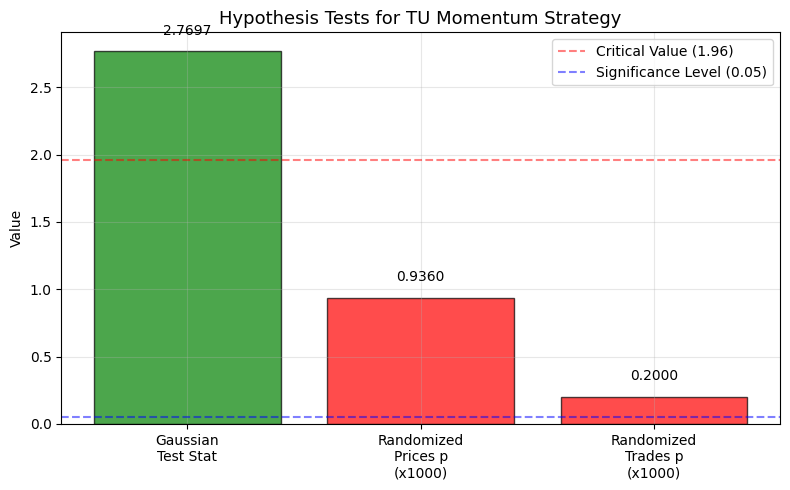

In [8]:
# === 가설 검정 결과 차트 ===

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
labels = ['Gaussian\nTest Stat', f'Randomized\nPrices p\n(x{n_sim})', f'Randomized\nTrades p\n(x{n_sim})']
values = [sharpe_stat, pval_prices, pval_trades]
colors = ['green', 'red', 'red']

bars = ax.bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=1.96, color='r', linestyle='--', alpha=0.5, label='Critical Value (1.96)')
ax.axhline(y=0.05, color='b', linestyle='--', alpha=0.5, label='Significance Level (0.05)')
ax.set_title('Hypothesis Tests for TU Momentum Strategy', fontsize=13)
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

---

## 6. 분석 4: 주식 횡단면 모멘텀 전략 (예제 6.2)

### 방법론

- Kent Daniel 스타일: 과거 252일 수익률로 ~500 종목 순위 매기기
- 상위 50종목 롱, 하위 50종목 숏
- 25일간 보유, 매일 리밸런스 (중첩)

In [9]:
# === 분석 4: 주식 횡단면 모멘텀 전략 ===

lookback_cs = 252
holddays_cs = 25
topN = 50

# 과거 수익률
ret_cs = cl.pct_change(periods=lookback_cs)

# 롱/숏 종목 선정 (상위/하위 topN)
longs_cs = np.full(cl.shape, False)
shorts_cs = np.full(cl.shape, False)
positions_cs = np.zeros(cl.shape)

for t in range(lookback_cs, cl.shape[0]):
    hasData = np.where(np.isfinite(ret_cs.iloc[t, :]))[0]
    if len(hasData) > 0:
        idxSort = np.argsort(ret_cs.iloc[t, hasData])
        n_select = min(topN, len(idxSort))
        longs_cs[t, hasData[idxSort.values[-n_select:]]] = True
        shorts_cs[t, hasData[idxSort.values[:n_select]]] = True

longs_cs = pd.DataFrame(longs_cs)
shorts_cs = pd.DataFrame(shorts_cs)

# 포지션 누적
for h in range(holddays_cs - 1):
    long_lag = longs_cs.shift(h).fillna(False).astype(bool).values
    short_lag = shorts_cs.shift(h).fillna(False).astype(bool).values
    positions_cs[long_lag] = positions_cs[long_lag] + 1
    positions_cs[short_lag] = positions_cs[short_lag] - 1

positions_cs = pd.DataFrame(positions_cs)

# 수익률 계산
ret_arr_cs = np.nansum((positions_cs.shift().values) * (cl.pct_change().values), axis=1) / (2 * topN) / holddays_cs
ret_strat_cs = pd.Series(ret_arr_cs, index=cl.index).fillna(0)

cumret_cs = (1 + ret_strat_cs).cumprod() - 1

apr_cs = float(np.prod(1 + ret_strat_cs.values) ** (252 / len(ret_strat_cs)) - 1)
sharpe_cs = float(np.sqrt(252) * np.mean(ret_strat_cs.values) / np.std(ret_strat_cs.values))
maxDD_cs, maxDDD_cs = calculateMaxDD(cumret_cs)

print(f'횡단면 모멘텀 전략 (LB={lookback_cs}, HD={holddays_cs}, TopN={topN})')
print(f'  APR      = {apr_cs*100:.2f}%')
print(f'  Sharpe   = {sharpe_cs:.4f}')
print(f'  Max DD   = {maxDD_cs*100:.2f}%')
print(f'  Max DDD  = {maxDDD_cs}일')

횡단면 모멘텀 전략 (LB=252, HD=25, TopN=50)
  APR      = -7.41%
  Sharpe   = -0.4370
  Max DD   = -59.51%
  Max DDD  = 953일


### 결과

| 지표 | 값 |
|------|-----|
| APR | -7.41% |
| Sharpe Ratio | -0.4370 |
| Max Drawdown | -59.51% |
| Max DDD | 953일 |

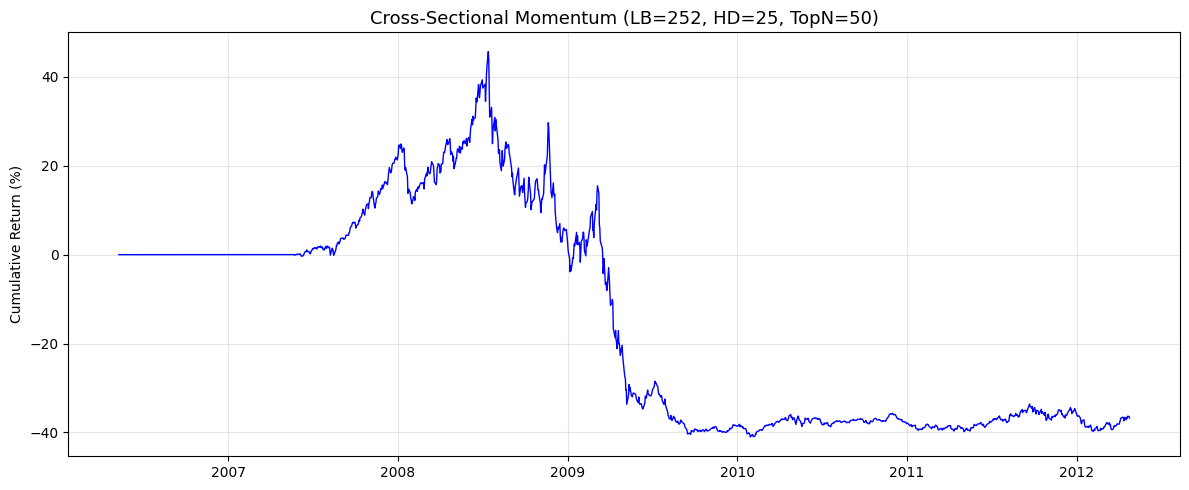

In [10]:
# === 횡단면 모멘텀 전략 차트 ===

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(cumret_cs.index, cumret_cs.values * 100, 'b-', linewidth=1)
ax.set_title(f'Cross-Sectional Momentum (LB={lookback_cs}, HD={holddays_cs}, TopN={topN})', fontsize=13)
ax.set_ylabel('Cumulative Return (%)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 7. 시계열 vs 횡단면 모멘텀 비교

| 구분 | 시계열 모멘텀 | 횡단면 모멘텀 |
|------|------------|------------|
| 신호 기반 | 절대 수익률 (자체 과거) | 상대 수익률 (종목 간 순위) |
| 자산 유형 | 선물 (단일 자산) | 주식 (대형 유니버스) |
| 포지션 | 롱 또는 숏 (1개) | 다수 롱 + 다수 숏 |
| 리스크 | 방향성 리스크 높음 | 시장 중립에 가까움 |
| APR | 1.92% | -7.41% |
| Sharpe | 1.09 | -0.44 |

---

## 8. 결론 및 권고사항

### 핵심 발견

1. **TU 선물에 모멘텀 존재**: 장기 lookback, 중기 holddays 조합에서 통계적으로 유의한 양의 상관관계
2. **가설 검정의 미묘함**: 가우시안 검정은 통과하나, 시장 수익률 자체의 분포 특성일 가능성
3. **횡단면 모멘텀**: 시장 중립에 가까워 방향성 리스크 낮음

### 주의사항

- **모멘텀 크래시**: 시장 반전 시 모멘텀 전략의 급격한 손실 가능
- **거래비용**: 높은 회전율로 인한 거래비용 고려 필요
- **시간 변화**: 모멘텀 효과는 시간이 지남에 따라 약화되는 경향